In [ ]:
!pip install torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 13.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn,optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler,random_split
from torchvision import models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import numpy as np
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix

In [ ]:
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor()])
  # Changing the image so that we can use it in our model
  all_images = datasets.ImageFolder(data_dir, transform=transform)
  train_images_len = int(len(all_images) *0.75)
  valid_images_len = int((len(all_images) - train_images_len)/2)
  test_images_len = int((len(all_images) - train_images_len - valid_images_len))
  train_data, val_data, test_data = random_split(all_images, [train_images_len, valid_images_len,test_images_len])
  train_loader = DataLoader(train_data, batch_size=batch_size)
  val_loader = DataLoader(val_data,batch_size=batch_size)
  test_loader = DataLoader(test_data,batch_size=batch_size)
  return (train_loader,val_loader,test_loader),all_images.classes

In [ ]:
(train_loader, val_loader,test_loader), classes = get_data_loaders("/content/drive/MyDrive/data/food11/train",64)

In [ ]:
print(classes)

['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 82.8MB/s]


In [ ]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)

11


In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)

In [ ]:
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}

In [ ]:
from ignite import metrics
trainer = create_supervised_trainer(model,optimizer,criterion, device=device)
evaluator = create_supervised_evaluator(model,device=device,metrics={'accuracy':Accuracy(),'loss':Loss(criterion),'cm':ConfusionMatrix(len(classes))})

@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".",end='')
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  evaluator.run(train_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print()
  print(f"Training results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
  evaluator.run(val_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print()
  print(f"Validation results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")


In [ ]:
trainer.run(train_loader, max_epochs=4)

Text(0.5, 1.0, 'Validation loss')

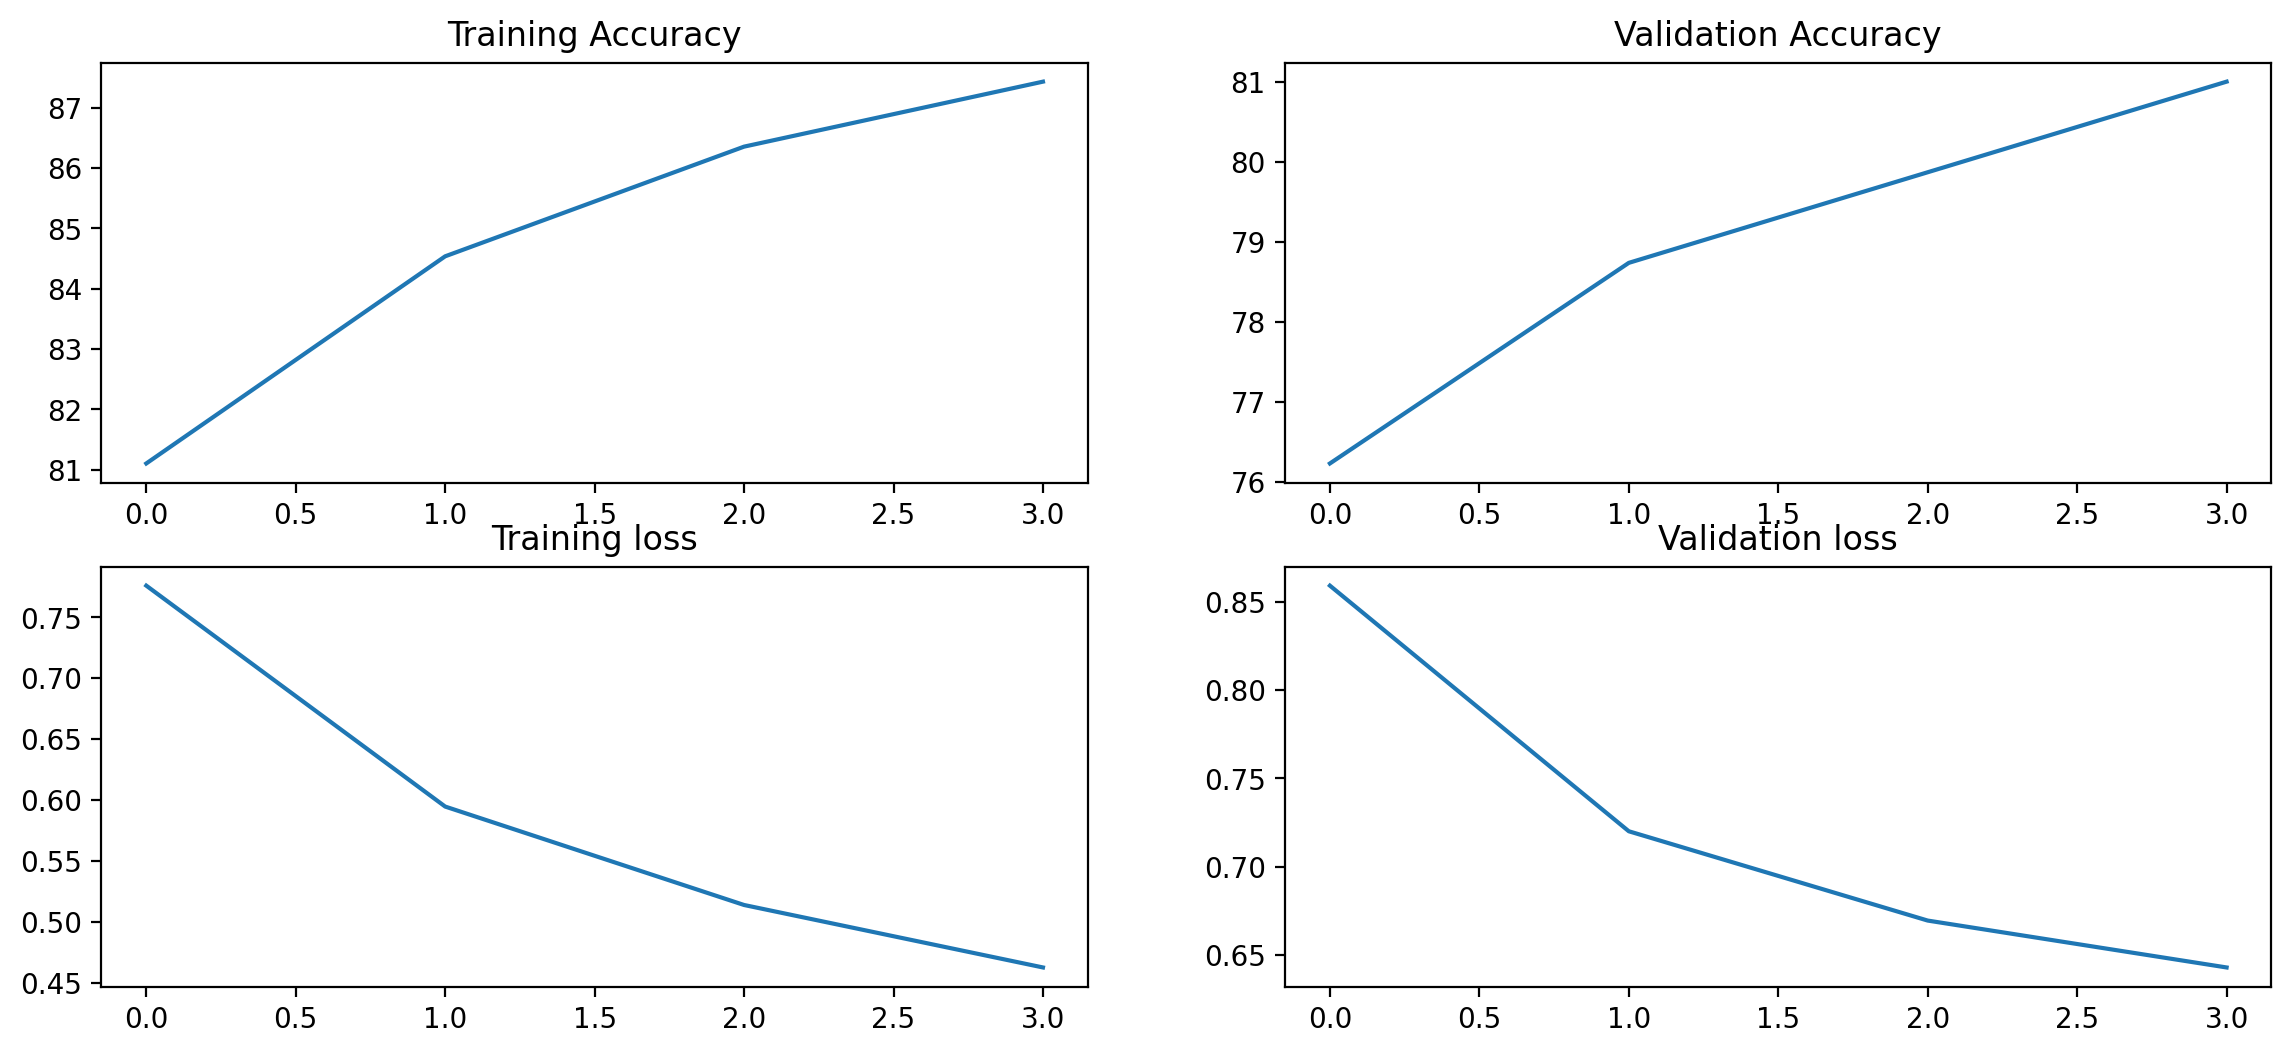

In [ ]:
fig,axe = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(14)
axe[0, 0].plot(training_history["accuracy"])
axe[0, 0].set_title("Training Accuracy")
axe[0, 1].plot(validation_history['accuracy'])
axe[0, 1].set_title("Validation Accuracy")
axe[1, 0].plot(training_history['loss'])
axe[1, 0].set_title("Training loss")
axe[1, 1].plot(validation_history['loss'])
axe[1, 1].set_title("Validation loss")

In [ ]:
test_loss = 0.0
class_correct = np.zeros((len(classes)))
class_total = np.zeros((len(classes)))
model.eval()
for data, target in test_loader:
  if torch.cuda.is_available():
    data,target = data.cuda(),target.cuda()
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) ==64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] +=1
test_loss /=len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i]>0:
    print("Text Accuracy of {}: {} ({}/{}) ".format(
        classes[i],100 *class_correct[i] / class_total[i],
        np.sum(class_correct[i]),np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Text Accuracy Overall: {} ({}/{}) ".format(
        100 *class_correct[i] / class_total[i],
        np.sum(class_correct[i]),np.sum(class_total[i])
    ))

Test Loss: 0.578068

Text Accuracy of apple_pie: 62.16216216216216 (69.0/111.0) 
Text Accuracy of cheesecake: 85.57692307692308 (89.0/104.0) 
Text Accuracy of chicken_curry: 80.16528925619835 (97.0/121.0) 
Text Accuracy of french_fries: 95.04132231404958 (115.0/121.0) 
Text Accuracy of fried_rice: 86.72566371681415 (98.0/113.0) 
Text Accuracy of hamburger: 85.71428571428571 (90.0/105.0) 
Text Accuracy of hot_dog: 77.04918032786885 (94.0/122.0) 
Text Accuracy of ice_cream: 85.56701030927834 (83.0/97.0) 
Text Accuracy of omelette: 70.11494252873563 (61.0/87.0) 
Text Accuracy of pizza: 93.27731092436974 (111.0/119.0) 
Text Accuracy of sushi: 75.86206896551724 (88.0/116.0) 
Text Accuracy Overall: 75.86206896551724 (88.0/116.0) 


In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def apply_test_transforms(inp):
  out = transforms.functional.resize(inp, [224,224])
  out = transforms.functional.to_tensor(out)
  out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  return out

In [ ]:
def predict (model, filepath, show_img=False, url=False):
  if url:
    response = requests.get(filepath)
    im = Image.open(BytesIO(response.content))
  else:
    im = Image.open(filepath)
  if show_img:
    plt.imshow(im)
  im_aa_tensor = apply_test_transforms(im)
  minibatch = torch.stack([im_aa_tensor])
  if torch.cuda.is_available():
    minibatch = minibatch.cuda()
  pred = model(minibatch)
  _,classnum = torch.max(pred,1)
  return classes[classnum]

In [ ]:
predict(model, "/content/drive/MyDrive/data/food11/test/hot_dog/101571.jpg", show_img=True, url=False)